<h1>STA 220 Assignment 3</h1>

In [1]:
import requests
from bs4 import BeautifulSoup
from requests_cache import CachedSession
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

(a, i) Write a function that retrieves all links to movies in the database by scraping the alphabetical section on imsdb.com and retrieve the links. How many links did you find?

In [2]:
base_url = "https://imsdb.com"

In [3]:
session = CachedSession()

In [4]:
def get_movie_links():
    """
    This function fetches movie links from a base URL.
    The base URL should be the main page of a website that lists movies alphabetically.
    """

    # Defining the sections for alphabetical listing
    alphabet_sections = list("0ABCDEFGHIJKLMNOPQRSTUVWXYZ")

    # Initializing an empty list to store all movie links
    all_movie_links = []

    # Creating a session object
    session = requests.Session()

    # Looping over each section
    for section in alphabet_sections:
        # Constructing the URL for the current section
        url = f"{base_url}/alphabetical/{section}"

        # Sending a GET request to the URL
        response = session.get(url)

        # Parsing the response content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Finding all 'p' tags in the parsed HTML
        p_tags = soup.find_all("p")

        # Looping over each 'p' tag
        for p_tag in p_tags:
            # Find the 'a' tag within the current 'p' tag
            movie_link = p_tag.find("a")

            # Constructing the full URL for the movie
            link = f"{base_url}{movie_link['href']}".replace(" ", "%20")

            # Appending the movie link to the list
            all_movie_links.append(link)

    # Returning the list of all movie links
    return all_movie_links


In [5]:
# Call the function to get all movie links
movie_links = get_movie_links()

# Print the total number of movie links retrieved
print(f"Total number of movie links: {len(movie_links)}")

Total number of movie links: 1218


(ii) Write a function fetch_script that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie:
fetch_script('/Movie Scripts/10 Things I Hate About You Script.html')

>>> {'title': '10 Things I Hate About You',
     'writers': ['Karen McCullah Lutz', 'Kirsten Smith', 'William Shakespeare'],
     'genres': ['Comedy', 'Romance'],
     'date': 1997,
     'script': '...'}

The script field contains a string of the scraped script. Retrieve the information for all movies. How many scripts did you retrieve?

In [6]:
def extract_siblings(tag):
    """
    This function extracts the text of sibling 'a' tags of a given tag until a 'b' tag is encountered.
    
    Parameters:
    tag (bs4.element.Tag): A BeautifulSoup tag object.

    Returns:
    list: A list of text from sibling 'a' tags.
    """

    # Initializing an empty list to store the text of sibling 'a' tags
    siblings = []

    # Looping over the next siblings of the given tag
    for sibling in tag.find_next_siblings():
        # If the sibling is an 'a' tag, append its text to the list
        if sibling.name == 'a':
            siblings.append(sibling.text)
        # If the sibling is a 'b' tag, break the loop
        elif sibling.name == 'b':
            break

    # Return the list of text from sibling 'a' tags
    return siblings

In [7]:
def extract_date(script_date):
    """
    This function extracts the date from a given BeautifulSoup tag.
    
    Parameters:
    script_date (bs4.element.Tag): A BeautifulSoup tag object.

    Returns:
    str: The extracted date as a string, or None if the tag is None.
    """

    # Initializing the date as None
    date = None

    # If the script_date tag is not None
    if script_date is not None:
        # Extract the date from the next sibling of the tag,
        # strip any leading/trailing whitespace,
        # split the string into words,
        # and take the last word which is the year
        date = script_date.next_sibling.strip().split(' ')[-1]

    # Return the date
    return date


In [8]:
def extract_script(table):
    """
    This function extracts the script from a given BeautifulSoup table tag.
    
    Parameters:
    table (bs4.element.Tag): A BeautifulSoup tag object.
    base_url (str): The base URL of the website.

    Returns:
    str: The extracted script as a string, or None if the script is not found.
    """

    # Find the 'a' tag in the table that contains the word "Script"
    script_link = table.find('a', string=lambda value: value and "Script" in value)

    # If the script link is found and it ends with '.html'
    if script_link and script_link['href'].endswith('.html'):
        # Construct the full URL for the script
        url = base_url + script_link['href']

        # Send a GET request to the script URL
        response = session.get(url)

        # Parse the response content with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the 'td' tag with class 'scrtext' in the parsed HTML
        td_tag = soup.find('td', {'class': 'scrtext'})

        # If the 'td' tag is found, return its text; otherwise, return None
        return td_tag.get_text() if td_tag else None

    # If the script link is not found or it does not end with '.html', return None
    return None

In [9]:
def fetch_script(movie_link):
    """
    This function fetches the script details from a given movie link.
    """

    # Send a GET request to the movie link
    response = session.get(movie_link)

    # Parse the response content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table with class 'script-details'
    table = soup.find('table', {'class': 'script-details'})

    # Extract the title from the 'h1' tag and remove the last 6 characters
    title = table.find('h1').string[:-6]

    # Extract the writers from the sibling tags of the 'b' tag with string 'Writers'
    writers_tag = table.find('b', string='Writers')
    writers = extract_siblings(writers_tag)
            
    # Extract the genres from the sibling tags of the 'b' tag with string 'Genres'
    genres_tag = table.find('b', string='Genres')
    genres = extract_siblings(genres_tag)
    
    # Extract the script date from the sibling tag of the 'b' tag with string 'Script Date'
    script_date = table.find('b', string='Script Date')
    date = extract_date(script_date)

    # Extract the script text
    script_text = extract_script(table)

    # Return a dictionary with the extracted details
    return {
        'title': title,
        'writers': writers,
        'genres': genres,
        'date': date,
        'script': script_text
    }

In [10]:
# Initialize an empty list to store the details of all movies
all_movie_details = []

# Initialize a counter for the number of scripts retrieved
script_count = 0

# Loop over each movie link
for link in movie_links:
    # Fetch the script and other details for the movie
    movie_details = fetch_script(link)

    # Append the movie details to the list
    all_movie_details.append(movie_details)

    # If a script was retrieved for the movie, increment the counter
    if movie_details['script'] is not None:
        script_count += 1

# Print the total number of scripts retrieved
print(f"Total number of scripts retrieved: {script_count}")

Total number of scripts retrieved: 1169


(b) We are interested in the genres 'Musical', 'Horror', and 'Romance'. Craft a barplot displaying the absolute counts for each of these categories. In each bar, color-code the fractions of movies that are also counted in another genres.

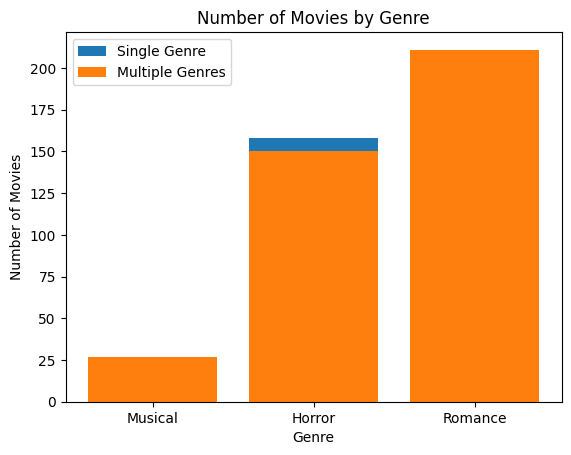

In [11]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_movie_details)

# Define the genres we're interested in
genres = ['Musical', 'Horror', 'Romance']

# Initialize a dictionary to store the counts for each genre
counts = {genre: 0 for genre in genres}
multi_genre_counts = {genre: 0 for genre in genres}

# Count the number of movies in each genre and the number of movies that are also in another genre
for details in all_movie_details:
    for genre in genres:
        if genre in details['genres']:
            counts[genre] += 1
            if len(details['genres']) > 1:
                multi_genre_counts[genre] += 1

# Calculate the fractions of movies that are also in another genre
fractions = {genre: multi_genre_counts[genre] / counts[genre] if counts[genre] > 0 else 0 for genre in genres}

# Create the bar plot
plt.bar(genres, [counts[genre] for genre in genres], label='Single Genre')
plt.bar(genres, [fractions[genre] * counts[genre] for genre in genres], label='Multiple Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.legend()
plt.show()

(c, i) Using only regex, write a function tokenizer that returns bigrams of all non-whitespace and non-punctuation characters, according to the test case below:

test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)
>>> ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']


In [12]:
def tokenizer(text):
    """
    This function tokenizes the input text into bigrams.
    
    Parameters:
    text (str): A string of text.

    Returns:
    list: A list of bigrams.
    """

    # Use a regular expression to find all words in the text
    # Convert the text to lowercase to ensure case-insensitivity
    words = re.findall(r'\b\w+\b', text.lower())

    # Create bigrams from the list of words and return them
    return [' '.join(words[i:i+2]) for i in range(len(words)-1)]

# Define a test string
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''

# Print the bigrams of the test string
print(tokenizer(test))


['neque porro', 'porro quisquam', 'quisquam est', 'est qui', 'qui dolorem', 'dolorem ipsum', 'ipsum quia', 'quia dolor', 'dolor sit', 'sit amet', 'amet consectetur', 'consectetur adipisci', 'adipisci velit', 'velit sed', 'sed quia', 'quia non', 'non numquam', 'numquam eius', 'eius modi', 'modi tempora', 'tempora incidunt', 'incidunt ut', 'ut labore', 'labore et', 'et dolore', 'dolore magnam', 'magnam aliquam', 'aliquam quaerat', 'quaerat voluptatem']


(ii) Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (sklearn.decomposition.TruncatedSVD). What fraction of variation is explained by the first principal component? 

In [13]:
# Extract scripts from all_movie_details where script is not None
scripts = [movie['script'] for movie in all_movie_details if movie['script'] is not None]

# Initialize a TfidfVectorizer with the custom tokenizer function
# The token_pattern=None is used because we are providing a custom tokenizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)

# Fit the vectorizer to the scripts and transform the scripts into tf-idf vectors
tfidf_matrix = vectorizer.fit_transform(scripts)

# Print the tf-idf matrix
print(tfidf_matrix)


  (0, 4859348)	0.0009577082290019003
  (0, 1084347)	0.0009577082290019003
  (0, 5051698)	0.0009577082290019003
  (0, 3966334)	0.002939279023342966
  (0, 1078014)	0.004071049081388899
  (0, 1956307)	0.002354462624935982
  (0, 4174554)	0.006660141457550654
  (0, 4332812)	0.00638509653399637
  (0, 5338212)	0.00638509653399637
  (0, 5381886)	0.00638509653399637
  (0, 7040)	0.007047795504648885
  (0, 1573548)	0.00638509653399637
  (0, 3465402)	0.004595517912475102
  (0, 1689429)	0.0016760182798153205
  (0, 5373629)	0.005121402099139645
  (0, 3758307)	0.006660141457550654
  (0, 1987182)	0.007047795504648885
  (0, 314330)	0.0031493740111206243
  (0, 1186586)	0.003734300651386313
  (0, 5179479)	0.004050035652687027
  (0, 1977588)	0.005001737057824397
  (0, 3610823)	0.007047795504648885
  (0, 2353155)	0.005001737057824397
  (0, 639414)	0.007047795504648885
  (0, 471471)	0.007047795504648885
  :	:
  (1168, 5220979)	0.0026149632246522505
  (1168, 4858821)	0.0009391246324458215
  (1168, 3482444)	0

In [14]:
# Perform PCA
svd = TruncatedSVD(n_components=1)
principal_components = svd.fit_transform(tfidf_matrix)

# The fraction of variation explained by the first principal component
print(f"Fraction of variation explained by the first principal component: {svd.explained_variance_ratio_[0]}")


Fraction of variation explained by the first principal component: 0.004905398903747563


(iii) Generate a strip-plot for the first principal components versus all three genres.

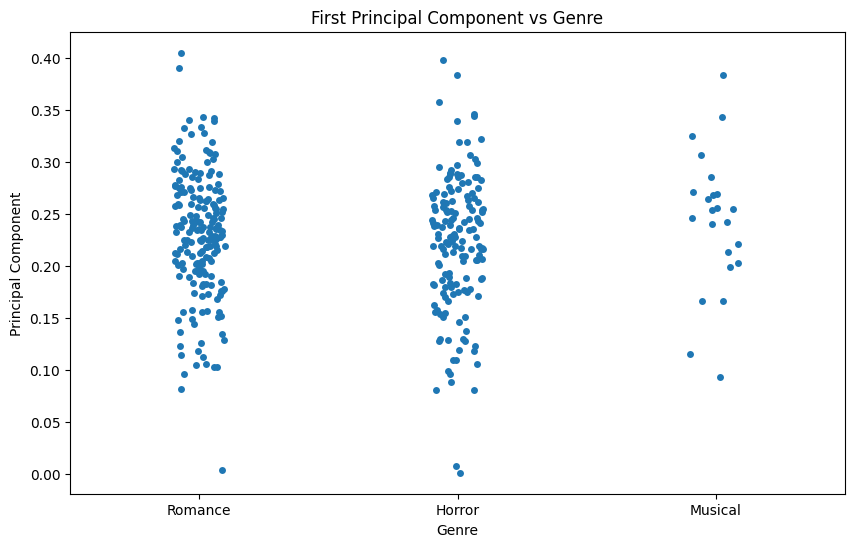

In [15]:
# Add the principal components to the corresponding movie dictionaries
for movie, pc in zip(all_movie_details, principal_components):
    # Only add the principal component if the script is not None
    if movie['script'] is not None:
        movie['principal_component'] = pc[0]

# Extract the principal components from each movie dictionary
# If a movie does not have a 'principal_component' key, default to None
principal_components = [movie.get('principal_component', None) for movie in all_movie_details]

# Define the genres of interest
genres = ['Musical', 'Horror', 'Romance']

# Initialize an empty list to store the data
data = []

# Loop over each movie and its principal component
for movie, pc in zip(all_movie_details, principal_components):
    # Only proceed if the principal component is not None
    if pc is not None:
        # Loop over each genre in the movie's genres
        for genre in movie['genres']:
            # Only proceed if the genre is one of the genres of interest
            if genre in genres:
                # Append a dictionary with the genre and principal component to the data list
                data.append({'Genre': genre, 'Principal Component': pc})

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Create a strip plot of the principal component by genre
plt.figure(figsize=(10, 6))
sns.stripplot(x='Genre', y='Principal Component', data=df, jitter=True)
plt.title('First Principal Component vs Genre')
plt.show()


Does visualization indicate that a good classification could result from this approach?

The visualization indicates that a good classification could result from this approach.
The principal component values for different genres are well-separated and form distinct clusters, it indicates that the first principal component is capturing some underlying patterns in the data that are specific to each genre. This is beneficial because it means that this component can be used as a feature to distinguish between these genres. 
The first principal component is providing information that helps to differentiate ‘Musical’, ‘Horror’, and ‘Romance’ movies based on their scripts. 